In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

la simulation chargée est: dahu_619
depuis: dahu
shape of psi: (145, 2048, 2048)
{'NX': 2048.0, 'NY': 2048.0, 'nl': 1.0, 'Lx': 502.65482457, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.00390625, 'tend': 1576800000000.0, 'dt_out': 0.05}


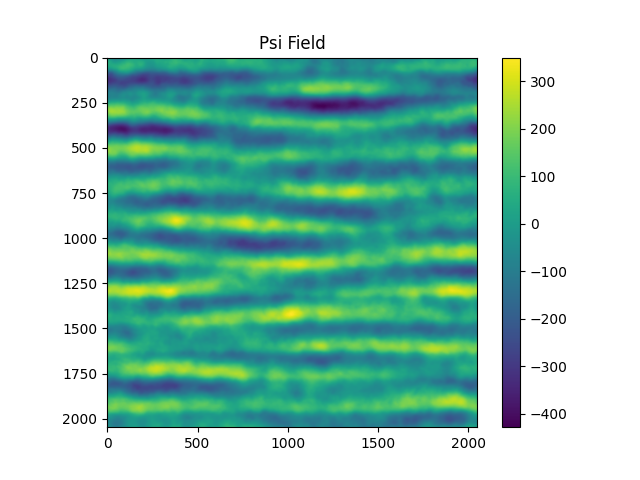

In [10]:
#Here Is to compuite the velocity field
# Number of simulation
n = 619

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    simu_name = f'outdir_{n:04d}'
    Path = f'/home/massoale/Simu_Test/qgw-main/src/{simu_name}/'
elif where == 'dahu':
    simu_name = f'dahu_{n}'
    Path = f'/home/massoale/Simu_Test/simu_dahu/simu_dahu{n}/outdir_0001/'
elif where == 'dahu_downsized':
    simu_name = f'dahu_{n}'
    Path = f'/home/massoale/Simu_Test/simu_dahu/simu_dahu{n}/outdir_downsized/'
    Path_bis = f'/home/massoale/Simu_Test/simu_dahu/simu_dahu{n}/outdir_0001/'
else:
    print('Error: where not recognized')
    sys.exit()

print(f'la simulation chargée est: {simu_name}')
print(f'depuis: {where}')

filenames = ['/vars.nc']

# Open the dataset using xarray with dask
dataset = xr.open_dataset(Path + filenames[0], chunks={'time': 1, 'x': 512, 'y': 512})

# Load variables
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel(level=0).data
q = dataset['q'].isel(level=0).data

print(f"shape of psi: {psi.shape}")

# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx, ny = 160, 160
    param['NX'], param['NY'] = nx, ny
else:
    param = io.read_params(Path)
    nx, ny = int(param['NX']), int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

print(param)

# Plot a single slice of psi to check the data
plt.figure()
plt.imshow(psi[-2, :, :], cmap='viridis')
plt.title('Psi Field')
plt.colorbar()
plt.show()




(2046, 2046) (2046, 2046) (2046, 2046)


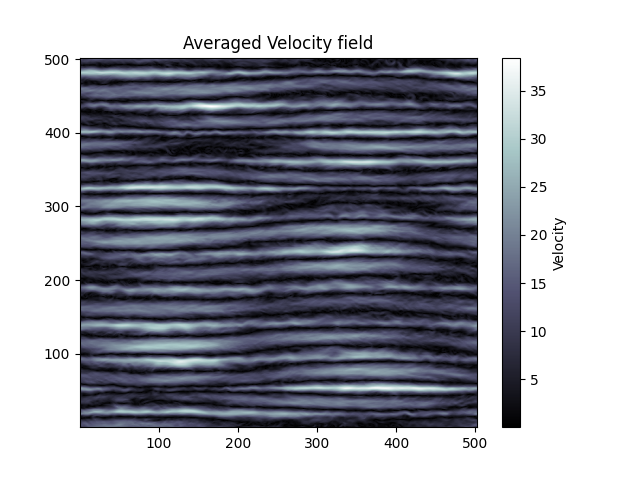

In [15]:
# Plotting the mean velocity field
time_start = 100

# Ensure psi_data is a dask array and rechunk if necessary
psi_data = psi[time_start:, :, :]
psi_data = psi_data.rechunk((1, 512, 512))
dx = x[-1] / x.shape[0]
dy = y[-1] / y.shape[0]

Lx = x[-1]  # Length of the domain
Ly = y[-1]  # Width of the domain

X, Y = np.meshgrid(x[1:-1], y[1:-1])

# Function to calculate velocity using dask
def calc_uv_dask(psi_chunk, dx, bc_fac):
    u = da.zeros_like(psi_chunk)
    v = da.zeros_like(psi_chunk)
    
    u = -(psi_chunk[:, 2:, 1:-1] - psi_chunk[:, :-2, 1:-1]) / (2 * dx)
    v = (psi_chunk[:, 1:-1, 2:] - psi_chunk[:, 1:-1, :-2]) / (2 * dx)
    
    return u, v

u, v = calc_uv_dask(psi_data, dx, bc_fac=bc_fac)
u_mean = u.mean(axis=0)
v_mean = v.mean(axis=0)
U = da.sqrt(u_mean**2 + v_mean**2).compute()
print(np.shape(U),np.shape(X),np.shape(Y))
plt.figure()
plt.pcolormesh(X, Y, U, shading='auto', cmap='bone')
plt.title(f'Averaged Velocity field')
plt.colorbar(label='Velocity')
plt.savefig(f'./figures/Velocity/Velocity_field_{simu_name}.png')
plt.show()